# Experiments with Similarity Encoders (SimEc)
To show that SimEc can predict pairwise relations between data points and learn similarity preserving embeddings by mapping feature vectors into an embedding space where a given target similarity matrix can be approximated by the scalar product of the embedding vectors.

In [1]:
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

from simec import SimilarityEncoder
from utils import center_K, check_similarity_match
from utils_plotting import get_colors, plot_mnist, plot_mnist2

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = True

Using TensorFlow backend.


In [2]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
# scale
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

### Embedding MNIST based on class based similarities

In [3]:
# compute similarity matrix based on class labels
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
Y = np.tile(y_test, (len(y_test), 1))
S_test = center_K(np.array(Y==Y.T, dtype=int))

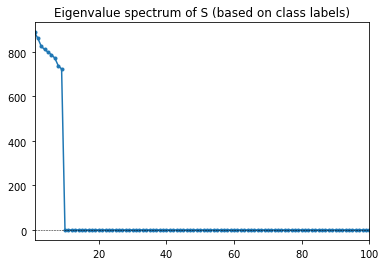

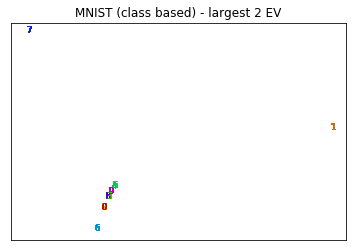

In [4]:
# compute the eigendecomposition of S as the perfect solution
D, V = np.linalg.eig(S)
# embedding based on largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
# check how many relevant dimensions there are
plt.figure();
plt.plot(range(1, S.shape[0]+1), D1.real, '-o', markersize=3);
plt.plot([1, S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue spectrum of S (based on class labels)');
# the embedding itself is not so impressive...
plot_mnist(X_embed[:,:2], y, title='MNIST (class based) - largest 2 EV')

Ridge Regression with alpha: 75.0
2
Epoch 1/25
8000/8000 [==============================] - 2s 218us/step - loss: 0.1282
Epoch 2/25
8000/8000 [==============================] - 1s 139us/step - loss: 0.1200
Epoch 3/25
8000/8000 [==============================] - 1s 135us/step - loss: 0.1188
Epoch 4/25
8000/8000 [==============================] - 1s 137us/step - loss: 0.1182
Epoch 5/25
8000/8000 [==============================] - 1s 136us/step - loss: 0.1177
Epoch 6/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1173
Epoch 7/25
8000/8000 [==============================] - 1s 141us/step - loss: 0.1168
Epoch 8/25
8000/8000 [==============================] - 1s 141us/step - loss: 0.1162
Epoch 9/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1156
Epoch 10/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1148
Epoch 11/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1138
Epoch 12/25
8000/8000 [====

Epoch 12/25
8000/8000 [==============================] - 1s 171us/step - loss: 0.0671
Epoch 13/25
8000/8000 [==============================] - 1s 171us/step - loss: 0.0656
Epoch 14/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0648
Epoch 15/25
8000/8000 [==============================] - 1s 171us/step - loss: 0.0641
Epoch 16/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0633
Epoch 17/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0624
Epoch 18/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0613
Epoch 19/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0601
Epoch 20/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0592
Epoch 21/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0585
Epoch 22/25
8000/8000 [==============================] - 1s 168us/step - loss: 0.0581
Epoch 23/25
8000/8000 [==============================]

8000/8000 [==============================] - 1s 144us/step - loss: 0.0376
Epoch 22/25
8000/8000 [==============================] - 1s 145us/step - loss: 0.0376
Epoch 23/25
8000/8000 [==============================] - 1s 143us/step - loss: 0.0375
Epoch 24/25
8000/8000 [==============================] - 1s 144us/step - loss: 0.0373
Epoch 25/25
8000/8000 [==============================] - 1s 141us/step - loss: 0.0373
Epoch 1/25
8000/8000 [==============================] - 2s 241us/step - loss: 0.1132
Epoch 2/25
8000/8000 [==============================] - 1s 174us/step - loss: 0.0924
Epoch 3/25
8000/8000 [==============================] - 1s 172us/step - loss: 0.0853
Epoch 4/25
8000/8000 [==============================] - 1s 169us/step - loss: 0.0788
Epoch 5/25
8000/8000 [==============================] - 1s 168us/step - loss: 0.0734
Epoch 6/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0677
Epoch 7/25
8000/8000 [==============================] - 1s 169us/step - 

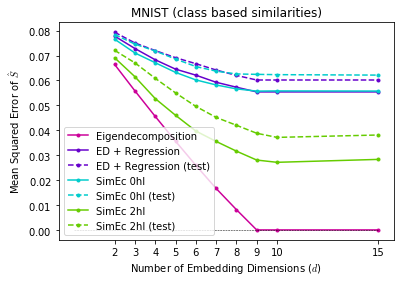

In [5]:
n_targets = 2000
# get good alpha for RR model
m = Ridge()
rrm = GridSearchCV(m, {'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1., 2.5, 5., 7.5, 10., 25., 50., 75., 100., 250., 500., 750., 1000.]})
rrm.fit(X, X_embed[:,:8])
alpha = rrm.best_params_["alpha"]
print("Ridge Regression with alpha: %r" % alpha)
mse_ev, mse_rr, mse_rr_test = [], [], []
mse_simec, mse_simec_test = [], []
mse_simec_hl, mse_simec_hl_test = [], []
e_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
for e_dim in e_dims:
    print e_dim
    # eigenvalue based embedding
    mse = check_similarity_match(X_embed[:,:e_dim], S)[0]
    mse_ev.append(mse)
    # train a linear ridge regression model to learn the mapping from X to Y
    model = Ridge(alpha=alpha)
    model.fit(X, X_embed[:,:e_dim])
    X_embed_r = model.predict(X)
    X_embed_test_r = model.predict(X_test)
    mse = check_similarity_match(X_embed_r, S)[0]
    mse_rr.append(mse)
    mse = check_similarity_match(X_embed_test_r, S_test)[0]
    mse_rr_test.append(mse)
    # simec - linear
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets],
                              orth_reg=0.001 if e_dim > 8 else 0., l2_reg_emb=0.00001, 
                              l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.001))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_test.append(mse_t)
    # simec - 2hl
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], orth_reg=0.001 if e_dim > 7 else 0., 
                              l2_reg=0., l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.001))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec_hl.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_hl_test.append(mse_t)
    print "mse ev: %f; mse rr: %f (%f); mse simec (0hl): %f (%f); mse simec (2hl): %f (%f)" % (mse_ev[-1], mse_rr[-1], mse_rr_test[-1], mse_simec[-1], mse_simec_test[-1], mse, mse_t)
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_ev, '-o', markersize=3, c=colors[14], label='Eigendecomposition');
plt.plot(e_dims, mse_rr, '-o', markersize=3, c=colors[12], label='ED + Regression');
plt.plot(e_dims, mse_rr_test, '--o', markersize=3, c=colors[12], label='ED + Regression (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc 0hl');
plt.plot(e_dims, mse_simec_test, '--o', markersize=3, c=colors[8], label='SimEc 0hl (test)');
plt.plot(e_dims, mse_simec_hl, '-o', markersize=3, c=colors[4], label='SimEc 2hl');
plt.plot(e_dims, mse_simec_hl_test, '--o', markersize=3, c=colors[4], label='SimEc 2hl (test)');
plt.legend(loc=0);
plt.title('MNIST (class based similarities)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "e_dims=", e_dims
print "mse_ev=", mse_ev
print "mse_rr=", mse_rr
print "mse_rr_test=", mse_rr_test
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
print "mse_simec_hl=", mse_simec_hl
print "mse_simec_hl_test=", mse_simec_hl_test
if savefigs: plt.savefig('fig_class_mse_edim.pdf', dpi=300)

### Embedding MNIST based on RBF kernel: embedding vs. prediction; number of targets; missing values

In [6]:
# Compute Gaussian kernel
D = squareform(pdist(X, 'euclidean'))
sigma = np.median(D)
gamma = 0.5/(sigma**2)
print("gamma: %.5f" % gamma)
K_rbf = center_K(rbf_kernel(X, X, gamma))
K_rbf_test = center_K(rbf_kernel(X_test, X_test, gamma))
K_rbf_test_train = center_K(rbf_kernel(np.concatenate([X,X_test]), np.concatenate([X,X_test]), gamma))[n_train:, :n_train]
# scale to be in the range [-1, 1]?
print np.max(np.abs(K_rbf))

gamma: 0.00475
0.735166002796


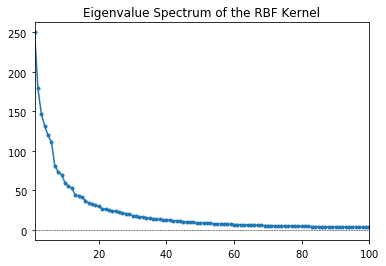

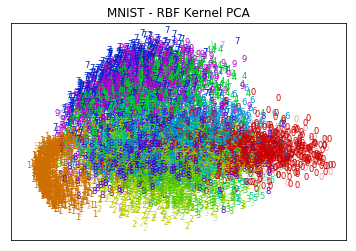

In [7]:
# check how many relevant dimensions there are
eigenvals = np.linalg.eigvalsh(K_rbf)[::-1]
plt.figure();
plt.plot(range(1, K_rbf.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1, K_rbf.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, 100);
plt.title('Eigenvalue Spectrum of the RBF Kernel');
# kernel PCA embedding
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - RBF Kernel PCA')

Epoch 1/25
8000/8000 [==============================] - 1s 154us/step - loss: 0.0017
Epoch 2/25
8000/8000 [==============================] - 1s 135us/step - loss: 7.2949e-04
Epoch 3/25
8000/8000 [==============================] - 1s 135us/step - loss: 5.5195e-04
Epoch 4/25
8000/8000 [==============================] - 1s 138us/step - loss: 4.8630e-04
Epoch 5/25
8000/8000 [==============================] - 1s 133us/step - loss: 4.6890e-04
Epoch 6/25
8000/8000 [==============================] - 1s 131us/step - loss: 4.6224e-04
Epoch 7/25
8000/8000 [==============================] - 1s 133us/step - loss: 4.5897e-04
Epoch 8/25
8000/8000 [==============================] - 1s 139us/step - loss: 4.5687e-04
Epoch 9/25
8000/8000 [==============================] - 1s 130us/step - loss: 4.5536e-04
Epoch 10/25
8000/8000 [==============================] - 1s 131us/step - loss: 4.5449e-04
Epoch 11/25
8000/8000 [==============================] - 1s 135us/step - loss: 4.5349e-04
Epoch 12/25
8000/8000 [

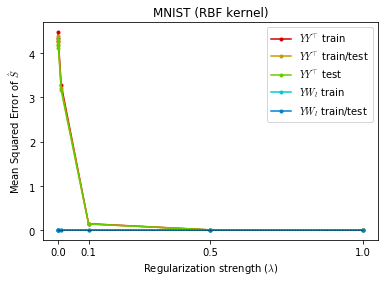

In [8]:
e_dim = 10
mse_train, mse_test, mse_traintest, mse_pred_train, mse_pred_tt = [], [], [], [], []
s_ll_regs = [0., 0.0001, 0.001, 0.01, 0.1, 0.5, 1.]
for l in s_ll_regs:
    simec = SimilarityEncoder(X.shape[1], e_dim, K_rbf.shape[1], hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              s_ll_reg=l, S_ll=K_rbf, opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf)
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, K_rbf)[0]
    mse_t = check_similarity_match(X_embed_tests, K_rbf_test)[0]
    mse_tt = check_similarity_match(X_embed_tests.dot(X_embeds.T), K_rbf_test_train, X_embed_is_S_approx=True)[0]
    mse_p = check_similarity_match(simec.predict(X), K_rbf, X_embed_is_S_approx=True)[0]
    mse_pt = check_similarity_match(simec.predict(X_test), K_rbf_test_train, X_embed_is_S_approx=True)[0]
    mse_train.append(mse)
    mse_test.append(mse_t)
    mse_traintest.append(mse_tt)
    mse_pred_train.append(mse_p)
    mse_pred_tt.append(mse_pt)
    print "embedding: %.5f (%.5f; %.5f); prediction: %.5f (%.5f)" % (mse, mse_tt, mse_t, mse_p, mse_pt)
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(s_ll_regs, mse_train, '-o', markersize=3, c=colors[0], label='$YY^{\\top}$ train');
plt.plot(s_ll_regs, mse_traintest, '-o', markersize=3, c=colors[2], label='$YY^{\\top}$ train/test');
plt.plot(s_ll_regs, mse_test, '-o', markersize=3, c=colors[4], label='$YY^{\\top}$ test');
plt.plot(s_ll_regs, mse_pred_train, '-o', markersize=3, c=colors[8], label='$YW_l$ train');
plt.plot(s_ll_regs, mse_pred_tt, '-o', markersize=3, c=colors[9], label='$YW_l$ train/test');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.plot([0, s_ll_regs[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks([0., 0.1, 0.5, 1.], [0., 0.1, 0.5, 1.]);
plt.xlabel('Regularization strength ($\lambda$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "s_ll_regs=", s_ll_regs
print "mse_train=", mse_train
print "mse_traintest=", mse_traintest
print "mse_test=", mse_test
print "mse_pred_train=", mse_pred_train
print "mse_pred_tt=", mse_pred_tt
if savefigs: plt.savefig('fig_rbf_mse_sllreg.pdf', dpi=300)

100
Epoch 1/25
8000/8000 [==============================] - 1s 143us/step - loss: 0.0308
Epoch 2/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0202
Epoch 3/25
8000/8000 [==============================] - 1s 120us/step - loss: 0.0117
Epoch 4/25
8000/8000 [==============================] - 1s 118us/step - loss: 0.0077
Epoch 5/25
8000/8000 [==============================] - 1s 124us/step - loss: 0.0062
Epoch 6/25
8000/8000 [==============================] - 1s 117us/step - loss: 0.0055
Epoch 7/25
8000/8000 [==============================] - 1s 117us/step - loss: 0.0053
Epoch 8/25
8000/8000 [==============================] - 1s 121us/step - loss: 0.0052
Epoch 9/25
8000/8000 [==============================] - 1s 119us/step - loss: 0.0051
Epoch 10/25
8000/8000 [==============================] - 1s 114us/step - loss: 0.0050
Epoch 11/25
8000/8000 [==============================] - 1s 119us/step - loss: 0.0050
Epoch 12/25
8000/8000 [==============================] - 1s

8000/8000 [==============================] - 4s 465us/step - loss: 0.0028
Epoch 12/25
8000/8000 [==============================] - 4s 465us/step - loss: 0.0028
Epoch 13/25
8000/8000 [==============================] - 4s 462us/step - loss: 0.0028
Epoch 14/25
8000/8000 [==============================] - 4s 465us/step - loss: 0.0028
Epoch 15/25
8000/8000 [==============================] - 4s 465us/step - loss: 0.0028
Epoch 16/25
8000/8000 [==============================] - 4s 464us/step - loss: 0.0028
Epoch 17/25
8000/8000 [==============================] - 4s 464us/step - loss: 0.0028
Epoch 18/25
8000/8000 [==============================] - 4s 463us/step - loss: 0.0028
Epoch 19/25
8000/8000 [==============================] - 4s 465us/step - loss: 0.0027
Epoch 20/25
8000/8000 [==============================] - 4s 464us/step - loss: 0.0027
Epoch 21/25
8000/8000 [==============================] - 4s 467us/step - loss: 0.0027
Epoch 22/25
8000/8000 [==============================] - 4s 465us/

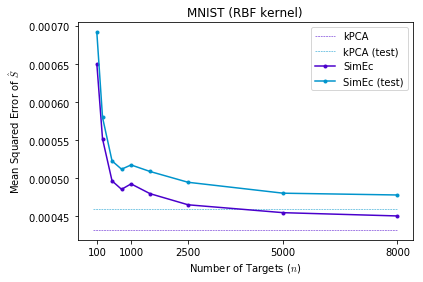

In [9]:
# check effect of different number of targets
e_dim = 10
mse_simec, mse_simec_test = [], []
targets = [100, 250, 500, 750, 1000, 1500, 2500, 5000, n_train]
kpca = KernelPCA(n_components=e_dim, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_rbf)[0]
mse_kt = check_similarity_match(X_embed_test, K_rbf_test)[0]
for n in targets:
    print n
    simec = SimilarityEncoder(X.shape[1], e_dim, n, hidden_layers=[(1000, 'tanh')], 
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              s_ll_reg=5., S_ll=K_rbf[:n,:n], opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf[:,:n])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_rbf)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_rbf_test)[0]
    mse_simec_test.append(mse_t)
    print "mse kpca: %f (%f); mse simec: %f (%f)" % (mse_k, mse_kt, mse, mse_t)
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA');
plt.plot([0, targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test)');
plt.plot(targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.xticks([100, 1000, 2500, 5000, 8000], [100, 1000, 2500, 5000, 8000]);
plt.xlabel('Number of Targets ($n$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "targets=", targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_rbf_mse_ntargets.pdf', dpi=300)

0.0
Epoch 1/25
8000/8000 [==============================] - 2s 199us/step - loss: 0.0176
Epoch 2/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0089
Epoch 3/25
8000/8000 [==============================] - 1s 160us/step - loss: 0.0046
Epoch 4/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0033
Epoch 5/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0030
Epoch 6/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0030
Epoch 7/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0029
Epoch 8/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0029
Epoch 9/25
8000/8000 [==============================] - 1s 168us/step - loss: 0.0029
Epoch 10/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0029
Epoch 11/25
8000/8000 [==============================] - 1s 162us/step - loss: 0.0029
Epoch 12/25
8000/8000 [==============================] - 1s

8000/8000 [==============================] - 1s 166us/step - loss: 0.0029
Epoch 10/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0029
Epoch 11/25
8000/8000 [==============================] - 1s 160us/step - loss: 0.0029
Epoch 12/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0029
Epoch 13/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0028
Epoch 14/25
8000/8000 [==============================] - 1s 166us/step - loss: 0.0028
Epoch 15/25
8000/8000 [==============================] - 1s 162us/step - loss: 0.0028
Epoch 16/25
8000/8000 [==============================] - 1s 163us/step - loss: 0.0028
Epoch 17/25
8000/8000 [==============================] - 1s 163us/step - loss: 0.0028
Epoch 18/25
8000/8000 [==============================] - 1s 162us/step - loss: 0.0028
Epoch 19/25
8000/8000 [==============================] - 1s 162us/step - loss: 0.0028
Epoch 20/25
8000/8000 [==============================] - 1s 165us/

Epoch 1/25
8000/8000 [==============================] - 2s 235us/step - loss: 0.0204
Epoch 2/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0198
Epoch 3/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0192
Epoch 4/25
8000/8000 [==============================] - 1s 163us/step - loss: 0.0184
Epoch 5/25
8000/8000 [==============================] - 1s 161us/step - loss: 0.0175
Epoch 6/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0165
Epoch 7/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0153
Epoch 8/25
8000/8000 [==============================] - 1s 166us/step - loss: 0.0140
Epoch 9/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0124
Epoch 10/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0107
Epoch 11/25
8000/8000 [==============================] - 1s 163us/step - loss: 0.0092
Epoch 12/25
8000/8000 [==============================] - 1s 161

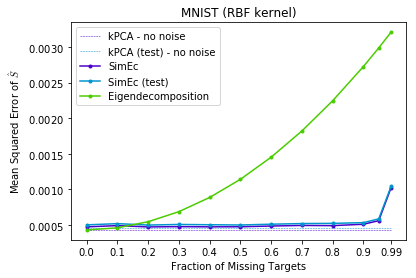

In [10]:
# missing targets
e_dim = 10
n_targets = 1500
np.random.seed(15)
k_mean = np.mean(K_rbf)
mse_ev = []
mse_simec, mse_simec_test = [], []
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=gamma)
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
mse_k = check_similarity_match(X_embed, K_rbf)[0]
mse_kt = check_similarity_match(X_embed_test, K_rbf_test)[0]
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
for m in missing_targets:
    print m
    K_rbf_noisy = K_rbf.copy()
    K_rbf_noisy[np.random.rand(*K_rbf_noisy.shape)<=m] = -100
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(1000, 'tanh')], mask_value=-100,
                              l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                              s_ll_reg=5., S_ll=K_rbf_noisy[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.0005))
    simec.fit(X, K_rbf_noisy[:,:n_targets])
    X_embed = simec.transform(X)
    X_embed_test = simec.transform(X_test)
    mse = check_similarity_match(X_embed, K_rbf)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_test, K_rbf_test)[0]
    mse_simec_test.append(mse_t)
    # eigendecomposition of matrix with missing values (filled in by mean)
    K_rbf_noisy[K_rbf_noisy==-100] = k_mean
    D, V = np.linalg.eig(K_rbf_noisy)
    # embedding based on largest EV
    D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
    X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
    mse_e = check_similarity_match(X_embed[:,:e_dim], K_rbf)[0]
    mse_ev.append(mse_e)
    print "mse kpca: %f (%f); mse evd: %f, mse simec: %f (%f)" % (mse_k, mse_kt, mse_e, mse, mse_t)
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot([0, missing_targets[-1]], [mse_k, mse_k], '--', linewidth=0.5, c=colors[8], label='kPCA - no noise');
plt.plot([0, missing_targets[-1]], [mse_kt, mse_kt], '--', linewidth=0.5, c=colors[6], label='kPCA (test) - no noise');
plt.plot(missing_targets, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc');
plt.plot(missing_targets, mse_simec_test, '-o', markersize=3, c=colors[6], label='SimEc (test)');
plt.plot(missing_targets, mse_ev, '-o', markersize=3, c=colors[3], label='Eigendecomposition');
plt.legend(loc=0);
plt.title('MNIST (RBF kernel)');
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99], [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]);
plt.xlabel('Fraction of Missing Targets')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "missing_targets=", missing_targets
print "mse_k=", mse_k
print "mse_kt=", mse_kt
print "mse_simec=", mse_simec
print "mse_simec_test=", mse_simec_test
if savefigs: plt.savefig('fig_rbf_mse_missingt.pdf', dpi=300)

### Embedding non-metric similarities and more

In [11]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X_org = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# only use 0 and 7
X_org = X_org[(y==0)|(y==7),:]
y = y[(y==0)|(y==7)]
X = np.array(X_org>=0.5, dtype=int)  # binarize
# randomly subsample 5000 and split in train/test
np.random.seed(42)
n_samples = 5000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X, X_org, y = X[rnd_idx,:], X_org[rnd_idx,:], y[rnd_idx]
# adapt the input data
ss = StandardScaler(with_std=False)
X_tf = ss.fit_transform(X_org)

In [12]:
# compute simpson similarity
# s_ij = sum(a==1 & b==1)/min(sum(a==1),sum(b==1))
sum_one = np.tile(np.sum(X, axis=1),(X.shape[0],1))
S = np.dot(X, X.T)/np.minimum(sum_one, sum_one.T, dtype=float)
# center
S = center_K(S)

[ 531.63744181  235.31839787  215.90045878  154.84834661  121.4820996
  111.22105789   94.46401417   75.34526218   64.11198688   61.37841461]
[  -9.46392977  -10.14040328  -13.21915609  -14.55947722  -15.86383925
  -16.48268389  -22.0225176   -35.22054468  -74.67616799 -131.97347336]


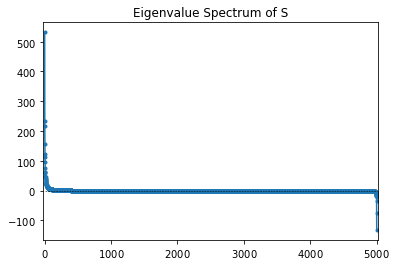

In [13]:
# check out the eigenvalue spectrum - we've got some significant negative eigenvalues!!
eigenvals = np.linalg.eigvalsh(S)[::-1]
print eigenvals[:10]
print eigenvals[-10:]
plt.figure();
plt.plot(range(1, S.shape[0]+1), eigenvals, '-o', markersize=3);
plt.plot([1,S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(-25, S.shape[0]+15);
plt.title('Eigenvalue Spectrum of S');
if savefigs: plt.savefig('fig_nonmetric_mnist07_evspec.pdf', dpi=300)

In [14]:
# compute embedding based on eigenvalues and -vectors
D, V = np.linalg.eig(S)
# regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed_largest = np.dot(V1, np.diag(np.sqrt(np.abs(D1))))
# feature discovery: based on absolute value of EV, i.e. also take most negative
D2, V2 = D[np.argsort(np.abs(D))[::-1]], V[:,np.argsort(np.abs(D))[::-1]]
X_embed_abs_imag = np.array(np.dot(V2, np.diag(np.sqrt(np.abs(D2)))), dtype=complex)
# to approximate S, dimensions belonging to negative EV need to be imaginary
X_embed_abs_imag[:, D2 < 0] *= 1j
# inspect similarity matrix: it's a combination of two simmats 
# S1 based on positive EV
S1 = np.dot(X_embed_largest[:, D1>=0], X_embed_largest[:, D1>=0].T)
# and S2 based on negative EV
S2 = np.dot(X_embed_largest[:, D1<0], X_embed_largest[:, D1<0].T)
print "S = S1-S2: %r " % np.allclose(S, S1-S2)

S = S1-S2: True 


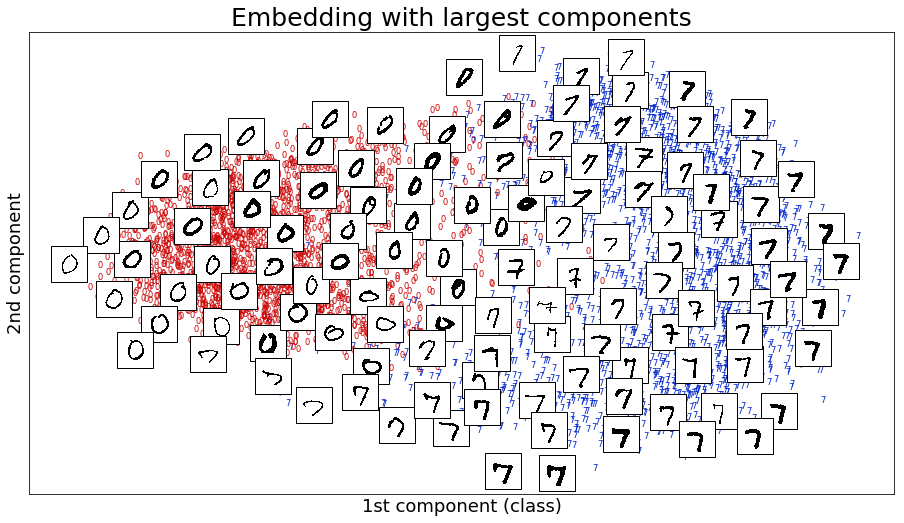

In [15]:
# plot largest
plot_mnist2(X_embed_largest[:,:2], y, X_original=X, title='Embedding with largest components')
plt.xlabel('1st component (class)', fontsize=18);
plt.ylabel('2nd component', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
if savefigs: plt.savefig('fig_nonmetric_mnist07_largest.png', dpi=300)

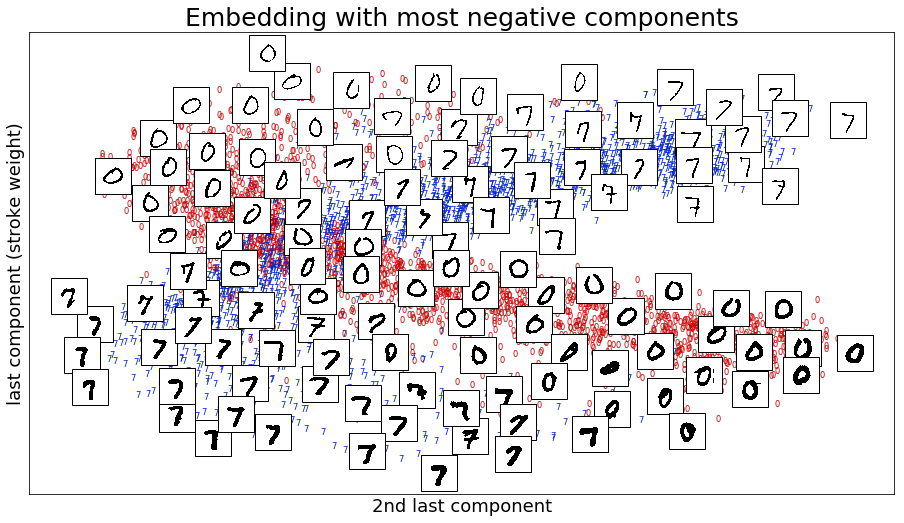

In [16]:
# plot smallest
plot_mnist2(X_embed_largest[:,-2:], y, X_original=X, title='Embedding with most negative components')
plt.xlabel('2nd last component', fontsize=18);
plt.ylabel('last component (stroke weight)', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
if savefigs: plt.savefig('fig_nonmetric_mnist07_smallest.png', dpi=300)

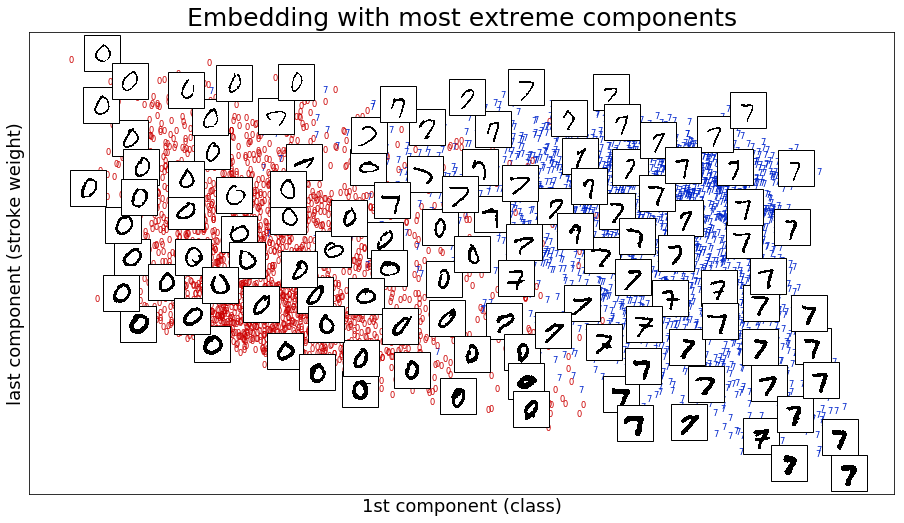

In [17]:
# plot most extreme
plot_mnist2(X_embed_largest[:,[0,-1]], y, X_original=X, title='Embedding with most extreme components')
plt.xlabel('1st component (class)', fontsize=18);
plt.ylabel('last component (stroke weight)', fontsize=18);
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)

2
Epoch 1/25
5000/5000 [==============================] - 1s 206us/step - loss: 0.0126
Epoch 2/25
5000/5000 [==============================] - 1s 103us/step - loss: 0.0086
Epoch 3/25
5000/5000 [==============================] - 1s 120us/step - loss: 0.0076
Epoch 4/25
5000/5000 [==============================] - 1s 115us/step - loss: 0.0075
Epoch 5/25
5000/5000 [==============================] - 1s 111us/step - loss: 0.0074
Epoch 6/25
5000/5000 [==============================] - 1s 112us/step - loss: 0.0073
Epoch 7/25
5000/5000 [==============================] - 1s 105us/step - loss: 0.0073
Epoch 8/25
5000/5000 [==============================] - 1s 107us/step - loss: 0.0073
Epoch 9/25
5000/5000 [==============================] - 1s 112us/step - loss: 0.0073
Epoch 10/25
5000/5000 [==============================] - 1s 112us/step - loss: 0.0072
Epoch 11/25
5000/5000 [==============================] - 1s 107us/step - loss: 0.0072
Epoch 12/25
5000/5000 [==============================] - 1s 1

5000/5000 [==============================] - 1s 114us/step - loss: 0.0011
Epoch 19/25
5000/5000 [==============================] - 1s 115us/step - loss: 0.0011
Epoch 20/25
5000/5000 [==============================] - 1s 114us/step - loss: 0.0010
Epoch 21/25
5000/5000 [==============================] - 1s 116us/step - loss: 0.0010
Epoch 22/25
5000/5000 [==============================] - 1s 115us/step - loss: 9.9954e-04
Epoch 23/25
5000/5000 [==============================] - 1s 120us/step - loss: 9.8047e-04
Epoch 24/25
5000/5000 [==============================] - 1s 109us/step - loss: 9.6480e-04
Epoch 25/25
5000/5000 [==============================] - 1s 112us/step - loss: 9.5122e-04
mse largest ev: 0.001406; mse abs largest ev: 0.000503; mse simec: 0.000757
50
Epoch 1/25
5000/5000 [==============================] - 1s 152us/step - loss: 0.0117
Epoch 2/25
5000/5000 [==============================] - 1s 124us/step - loss: 0.0051
Epoch 3/25
5000/5000 [==============================] - 1s 

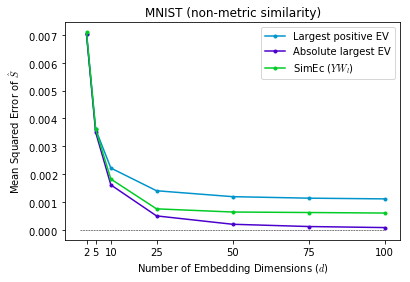

In [18]:
mse_ev_pos, mse_ev_abs, mse_simec = [], [], []
e_dims = [2, 5, 10, 25, 50, 75, 100]
for e_dim in e_dims:
    print e_dim
    # eigenvalue based embedding - largest (positive) eigenvalues
    mse_ev_pos.append(check_similarity_match(X_embed_largest[:,:e_dim], S)[0])
    # absolute largest eigenvalues
    mse_ev_abs.append(check_similarity_match(X_embed_abs_imag[:,:e_dim], S)[0])
    # simec embedding and prediction
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, S.shape[1], hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001, 
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S)
    mse = check_similarity_match(simec.predict(X_tf), S, X_embed_is_S_approx=True)[0]
    mse_simec.append(mse)
    print "mse largest ev: %f; mse abs largest ev: %f; mse simec: %f" % (mse_ev_pos[-1], mse_ev_abs[-1], mse)
keras.backend.clear_session()
colors = get_colors(10)
plt.figure();
plt.plot(e_dims, mse_ev_pos, '-o', markersize=3, c=colors[6], label='Largest positive EV');
plt.plot(e_dims, mse_ev_abs, '-o', markersize=3, c=colors[8], label='Absolute largest EV');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[4], label='SimEc ($YW_l$)');
plt.legend(loc=0);
plt.title('MNIST (non-metric similarity)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print "e_dims=", e_dims
print "mse_ev_pos=", mse_ev_pos
print "mse_ev_abs=", mse_ev_abs
print "mse_simec=", mse_simec
if savefigs: plt.savefig('fig_nonmetS_mse_edim.pdf', dpi=300)

In [19]:
# normalize individual similarity matrices by largest EV and add/stack
S1 /= np.linalg.norm(S1, ord=2)
S2 /= np.linalg.norm(S2, ord=2)
S1pS2 = S1 + S2
S1sS2 = np.stack([S1, S2], axis=2)
# normalize all to be within a reasonable range
m = np.max(np.abs(S1sS2))
S1 /= m
S2 /= m
S1pS2 /= m
S1sS2 /= m

In [20]:
# compute eigenvalue based embeddings for S1 and S2
D, V = np.linalg.eig(S1)
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed_s1 = np.dot(V1, np.diag(np.sqrt(np.abs(D1))))
D, V = np.linalg.eig(S2)
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed_s2 = np.dot(V1, np.diag(np.sqrt(np.abs(D1))))

Epoch 1/25
5000/5000 [==============================] - 4s 718us/step - loss: 0.0045
Epoch 2/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0037
Epoch 3/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0036
Epoch 4/25
5000/5000 [==============================] - 2s 454us/step - loss: 0.0035
Epoch 5/25
5000/5000 [==============================] - 2s 449us/step - loss: 0.0033
Epoch 6/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0031
Epoch 7/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0028
Epoch 8/25
5000/5000 [==============================] - 2s 450us/step - loss: 0.0025
Epoch 9/25
5000/5000 [==============================] - 2s 452us/step - loss: 0.0022
Epoch 10/25
5000/5000 [==============================] - 2s 453us/step - loss: 0.0021
Epoch 11/25
5000/5000 [==============================] - 2s 455us/step - loss: 0.0021
Epoch 12/25
5000/5000 [==============================] - 2s 454

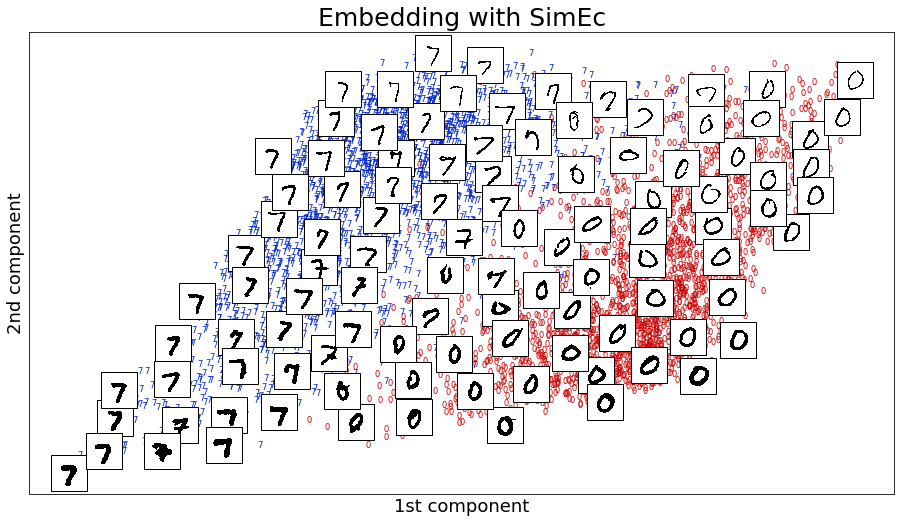

In [21]:
# by embedding the data with a simec based on the max ev normed added simmats
# we can preserve both features
simec = SimilarityEncoder(X_tf.shape[1], 2, S1pS2.shape[1], hidden_layers=[(200, 'tanh')],
                          l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001,
                          s_ll_reg=1., S_ll=S1pS2,
                          opt=keras.optimizers.Adamax(lr=0.0008))
simec.fit(X_tf, S1pS2)
X_embed = simec.transform(X_tf)
plot_mnist2(X_embed, y, X_original=X, title='Embedding with SimEc')
plt.xlabel('1st component', fontsize=18);
plt.ylabel('2nd component', fontsize=18);
fig = plt.gcf();
fig.set_size_inches(15.5, 8.5);
if savefigs: plt.savefig('fig_nonmetric_mnist07_simec.png', dpi=300)

2
Epoch 1/25
5000/5000 [==============================] - 4s 718us/step - loss: 0.0025
Epoch 2/25
5000/5000 [==============================] - 2s 452us/step - loss: 0.0019
Epoch 3/25
5000/5000 [==============================] - 2s 448us/step - loss: 0.0018
Epoch 4/25
5000/5000 [==============================] - 2s 450us/step - loss: 0.0017
Epoch 5/25
5000/5000 [==============================] - 2s 452us/step - loss: 0.0015
Epoch 6/25
5000/5000 [==============================] - 2s 450us/step - loss: 0.0013
Epoch 7/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0010
Epoch 8/25
5000/5000 [==============================] - 2s 452us/step - loss: 9.3189e-04
Epoch 9/25
5000/5000 [==============================] - 2s 453us/step - loss: 8.9820e-04
Epoch 10/25
5000/5000 [==============================] - 2s 452us/step - loss: 8.8662e-04
Epoch 11/25
5000/5000 [==============================] - 2s 452us/step - loss: 8.8183e-04
Epoch 12/25
5000/5000 [======================

Epoch 20/25
5000/5000 [==============================] - 4s 796us/step - loss: 0.0013
Epoch 21/25
5000/5000 [==============================] - 4s 806us/step - loss: 0.0013
Epoch 22/25
5000/5000 [==============================] - 4s 800us/step - loss: 0.0013
Epoch 23/25
5000/5000 [==============================] - 4s 796us/step - loss: 0.0013
Epoch 24/25
5000/5000 [==============================] - 4s 796us/step - loss: 0.0013
Epoch 25/25
5000/5000 [==============================] - 4s 794us/step - loss: 0.0013
mse S1: ev: 0.000416; s1: 0.000426 (0.000421); s1ps2: 0.001358 (0.001352); s1ss2: 0.001072 (0.000767)
mse S2: ev: 0.000163; s2: 0.000218 (0.000191); s1ps2: 0.001214 (0.001202); s1ss2: 0.000804 (0.000561)
5
Epoch 1/25
5000/5000 [==============================] - 4s 717us/step - loss: 0.0027
Epoch 2/25
5000/5000 [==============================] - 2s 453us/step - loss: 0.0018
Epoch 3/25
5000/5000 [==============================] - 2s 451us/step - loss: 0.0014
Epoch 4/25
5000/5000 [=

5000/5000 [==============================] - 4s 831us/step - loss: 7.3563e-04
Epoch 12/25
5000/5000 [==============================] - 4s 826us/step - loss: 7.2145e-04
Epoch 13/25
5000/5000 [==============================] - 4s 823us/step - loss: 7.0928e-04
Epoch 14/25
5000/5000 [==============================] - 4s 804us/step - loss: 7.0323e-04
Epoch 15/25
5000/5000 [==============================] - 4s 810us/step - loss: 6.9925e-04
Epoch 16/25
5000/5000 [==============================] - 4s 832us/step - loss: 6.9709e-04
Epoch 17/25
5000/5000 [==============================] - 4s 797us/step - loss: 6.9536e-04
Epoch 18/25
5000/5000 [==============================] - 4s 798us/step - loss: 6.9371e-04
Epoch 19/25
5000/5000 [==============================] - 4s 824us/step - loss: 6.9225e-04
Epoch 20/25
5000/5000 [==============================] - 4s 806us/step - loss: 6.9042e-04
Epoch 21/25
5000/5000 [==============================] - 4s 802us/step - loss: 6.8933e-04
Epoch 22/25
5000/5000 

5000/5000 [==============================] - 2s 449us/step - loss: 5.9948e-04
Epoch 1/25
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0042
Epoch 2/25
5000/5000 [==============================] - 4s 801us/step - loss: 0.0024
Epoch 3/25
5000/5000 [==============================] - 4s 802us/step - loss: 0.0014
Epoch 4/25
5000/5000 [==============================] - 4s 797us/step - loss: 9.8273e-04
Epoch 5/25
5000/5000 [==============================] - 4s 795us/step - loss: 7.4956e-04
Epoch 6/25
5000/5000 [==============================] - 4s 792us/step - loss: 6.5841e-04
Epoch 7/25
5000/5000 [==============================] - 4s 802us/step - loss: 5.9904e-04
Epoch 8/25
5000/5000 [==============================] - 4s 800us/step - loss: 5.4291e-04
Epoch 9/25
5000/5000 [==============================] - 4s 797us/step - loss: 5.0690e-04
Epoch 10/25
5000/5000 [==============================] - 4s 800us/step - loss: 4.8450e-04
Epoch 11/25
5000/5000 [======================

5000/5000 [==============================] - 2s 450us/step - loss: 4.9558e-04
Epoch 15/25
5000/5000 [==============================] - 2s 457us/step - loss: 4.7522e-04
Epoch 16/25
5000/5000 [==============================] - 2s 456us/step - loss: 4.5947e-04
Epoch 17/25
5000/5000 [==============================] - 2s 457us/step - loss: 4.4469e-04
Epoch 18/25
5000/5000 [==============================] - 2s 455us/step - loss: 4.3464e-04
Epoch 19/25
5000/5000 [==============================] - 2s 461us/step - loss: 4.2379e-04
Epoch 20/25
5000/5000 [==============================] - 2s 454us/step - loss: 4.1698e-04
Epoch 21/25
5000/5000 [==============================] - 2s 453us/step - loss: 4.1046e-04
Epoch 22/25
5000/5000 [==============================] - 2s 459us/step - loss: 4.0448e-04
Epoch 23/25
5000/5000 [==============================] - 2s 459us/step - loss: 3.9961e-04
Epoch 24/25
5000/5000 [==============================] - 2s 457us/step - loss: 3.9604e-04
Epoch 25/25
5000/5000 

5000/5000 [==============================] - 2s 468us/step - loss: 0.0026
Epoch 4/25
5000/5000 [==============================] - 2s 471us/step - loss: 0.0016
Epoch 5/25
5000/5000 [==============================] - 2s 468us/step - loss: 0.0011
Epoch 6/25
5000/5000 [==============================] - 2s 471us/step - loss: 8.8811e-04
Epoch 7/25
5000/5000 [==============================] - 2s 470us/step - loss: 7.5133e-04
Epoch 8/25
5000/5000 [==============================] - 2s 473us/step - loss: 6.6549e-04
Epoch 9/25
5000/5000 [==============================] - 2s 473us/step - loss: 6.0870e-04
Epoch 10/25
5000/5000 [==============================] - 2s 476us/step - loss: 5.7082e-04
Epoch 11/25
5000/5000 [==============================] - 2s 472us/step - loss: 5.3529e-04
Epoch 12/25
5000/5000 [==============================] - 2s 476us/step - loss: 5.0642e-04
Epoch 13/25
5000/5000 [==============================] - 2s 474us/step - loss: 4.7980e-04
Epoch 14/25
5000/5000 [=================

5000/5000 [==============================] - 3s 508us/step - loss: 2.5680e-04
Epoch 18/25
5000/5000 [==============================] - 3s 515us/step - loss: 2.4990e-04
Epoch 19/25
5000/5000 [==============================] - 3s 513us/step - loss: 2.4318e-04
Epoch 20/25
5000/5000 [==============================] - 3s 511us/step - loss: 2.3735e-04
Epoch 21/25
5000/5000 [==============================] - 3s 512us/step - loss: 2.3122e-04
Epoch 22/25
5000/5000 [==============================] - 3s 512us/step - loss: 2.2797e-04
Epoch 23/25
5000/5000 [==============================] - 3s 512us/step - loss: 2.2213e-04
Epoch 24/25
5000/5000 [==============================] - 3s 513us/step - loss: 2.1912e-04
Epoch 25/25
5000/5000 [==============================] - 3s 514us/step - loss: 2.1363e-04
Epoch 1/25
5000/5000 [==============================] - 4s 796us/step - loss: 0.0104
Epoch 2/25
5000/5000 [==============================] - 3s 527us/step - loss: 0.0048
Epoch 3/25
5000/5000 [==========

5000/5000 [==============================] - 3s 526us/step - loss: 5.5777e-04
Epoch 7/25
5000/5000 [==============================] - 3s 528us/step - loss: 4.8596e-04
Epoch 8/25
5000/5000 [==============================] - 3s 527us/step - loss: 4.3371e-04
Epoch 9/25
5000/5000 [==============================] - 3s 528us/step - loss: 3.9818e-04
Epoch 10/25
5000/5000 [==============================] - 3s 529us/step - loss: 3.6602e-04
Epoch 11/25
5000/5000 [==============================] - 3s 527us/step - loss: 3.4255e-04
Epoch 12/25
5000/5000 [==============================] - 3s 528us/step - loss: 3.1949e-04
Epoch 13/25
5000/5000 [==============================] - 3s 527us/step - loss: 3.0278e-04
Epoch 14/25
5000/5000 [==============================] - 3s 528us/step - loss: 2.9019e-04
Epoch 15/25
5000/5000 [==============================] - 3s 518us/step - loss: 2.7965e-04
Epoch 16/25
5000/5000 [==============================] - 3s 530us/step - loss: 2.7061e-04
Epoch 17/25
5000/5000 [==

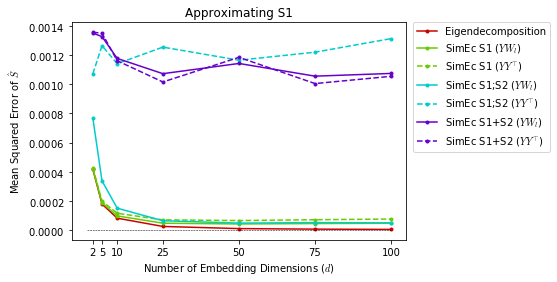

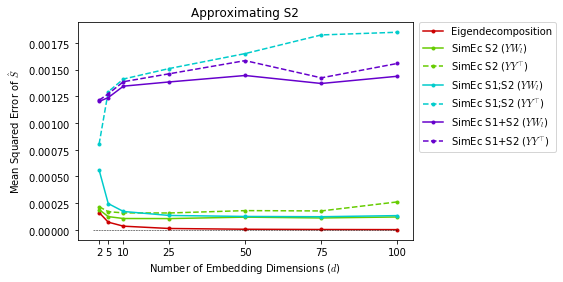

In [22]:
# check approximation errors for different numbers of edim
mse_ev_s1, mse_ev_s2 = [], []
mse_simec_pred_s1_s1, mse_simec_pred_s2_s2 = [], []
mse_simec_embed_s1_s1, mse_simec_embed_s2_s2 = [], []
mse_simec_pred_s1ps2_s1, mse_simec_pred_s1ps2_s2 = [], []
mse_simec_embed_s1ps2_s1, mse_simec_embed_s1ps2_s2 = [], []
mse_simec_pred_s1ss2_s1, mse_simec_pred_s1ss2_s2 = [], []
mse_simec_embed_s1ss2_s1, mse_simec_embed_s1ss2_s2 = [], []
e_dims = [2, 5, 10, 25, 50, 75, 100]
for e_dim in e_dims:
    print e_dim
    # eigenvalue based embedding for S1 and S2
    mse_ev_s1.append(check_similarity_match(X_embed_s1[:,:e_dim], S1)[0])
    mse_ev_s2.append(check_similarity_match(X_embed_s2[:,:e_dim], S2)[0])
    # simec embedding and prediction for S1
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, S1.shape[1], hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001,
                              s_ll_reg=1., S_ll=S1,
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S1)
    mse_simec_embed_s1_s1.append(check_similarity_match(simec.transform(X_tf), S1)[0])
    mse_simec_pred_s1_s1.append(check_similarity_match(simec.predict(X_tf), S1, X_embed_is_S_approx=True)[0])
    # simec embedding and prediction for S2
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, S2.shape[1], hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001,
                              s_ll_reg=1., S_ll=S2,
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S2)
    mse_simec_embed_s2_s2.append(check_similarity_match(simec.transform(X_tf), S2)[0])
    mse_simec_pred_s2_s2.append(check_similarity_match(simec.predict(X_tf), S2, X_embed_is_S_approx=True)[0])
    # simec embedding and prediction for S1pS2
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, S1pS2.shape[1], hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001,
                              s_ll_reg=1., S_ll=S1pS2,
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S1pS2)
    X_embed = simec.transform(X_tf)
    S_pred = simec.predict(X_tf)
    mse_simec_embed_s1ps2_s1.append(check_similarity_match(X_embed, S1)[0])
    mse_simec_embed_s1ps2_s2.append(check_similarity_match(X_embed, S2)[0])
    mse_simec_pred_s1ps2_s1.append(check_similarity_match(S_pred, S1, X_embed_is_S_approx=True)[0])
    mse_simec_pred_s1ps2_s2.append(check_similarity_match(S_pred, S2, X_embed_is_S_approx=True)[0])
    # simec embedding and prediction for S1sS2
    simec = SimilarityEncoder(X_tf.shape[1], e_dim, (S1sS2.shape[1], S1sS2.shape[2]), hidden_layers=[(200, 'tanh')],
                              l2_reg=0.0000001, l2_reg_emb=0.0001, l2_reg_out=0.0000001,
                              s_ll_reg=1., S_ll=S1sS2,
                              opt=keras.optimizers.Adamax(lr=0.0008))
    simec.fit(X_tf, S1sS2)
    X_embed = simec.transform(X_tf)
    S_pred = simec.predict(X_tf)
    mse_simec_embed_s1ss2_s1.append(check_similarity_match(X_embed, S1)[0])
    mse_simec_embed_s1ss2_s2.append(check_similarity_match(X_embed, S2)[0])
    mse_simec_pred_s1ss2_s1.append(check_similarity_match(S_pred[:,:,0], S1, X_embed_is_S_approx=True)[0])
    mse_simec_pred_s1ss2_s2.append(check_similarity_match(S_pred[:,:,1], S2, X_embed_is_S_approx=True)[0])
    print "mse S1: ev: %f; s1: %f (%f); s1ps2: %f (%f); s1ss2: %f (%f)" % (mse_ev_s1[-1], 
                                                                           mse_simec_embed_s1_s1[-1], mse_simec_pred_s1_s1[-1], 
                                                                           mse_simec_embed_s1ps2_s1[-1], mse_simec_pred_s1ps2_s1[-1], 
                                                                           mse_simec_embed_s1ss2_s1[-1], mse_simec_pred_s1ss2_s1[-1])
    print "mse S2: ev: %f; s2: %f (%f); s1ps2: %f (%f); s1ss2: %f (%f)" % (mse_ev_s2[-1], 
                                                                           mse_simec_embed_s2_s2[-1], mse_simec_pred_s2_s2[-1], 
                                                                           mse_simec_embed_s1ps2_s2[-1], mse_simec_pred_s1ps2_s2[-1], 
                                                                           mse_simec_embed_s1ss2_s2[-1], mse_simec_pred_s1ss2_s2[-1])
    keras.backend.clear_session()
print "e_dims=", e_dims
print "mse_ev_s1=", mse_ev_s1
print "mse_ev_s2=", mse_ev_s2
print "mse_simec_pred_s1_s1=", mse_simec_pred_s1_s1
print "mse_simec_pred_s2_s2=", mse_simec_pred_s2_s2
print "mse_simec_embed_s1_s1=", mse_simec_embed_s1_s1
print "mse_simec_embed_s2_s2=", mse_simec_embed_s2_s2
print "mse_simec_pred_s1ps2_s1=", mse_simec_pred_s1ps2_s1
print "mse_simec_pred_s1ps2_s2=", mse_simec_pred_s1ps2_s2
print "mse_simec_embed_s1ps2_s1=", mse_simec_embed_s1ps2_s1
print "mse_simec_embed_s1ps2_s2=", mse_simec_embed_s1ps2_s2
print "mse_simec_pred_s1ss2_s1=", mse_simec_pred_s1ss2_s1
print "mse_simec_pred_s1ss2_s2=", mse_simec_pred_s1ss2_s2
print "mse_simec_embed_s1ss2_s1=", mse_simec_embed_s1ss2_s1
print "mse_simec_embed_s1ss2_s2=", mse_simec_embed_s1ss2_s2
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_ev_s1, '-o', markersize=3, c=colors[0], label='Eigendecomposition');
plt.plot(e_dims, mse_simec_pred_s1_s1, '-o', markersize=3, c=colors[4], label='SimEc S1 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s1_s1, '--o', markersize=3, c=colors[4], label='SimEc S1 ($YY^{\\top}$)');
plt.plot(e_dims, mse_simec_pred_s1ss2_s1, '-o', markersize=3, c=colors[8], label='SimEc S1;S2 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s1ss2_s1, '--o', markersize=3, c=colors[8], label='SimEc S1;S2 ($YY^{\\top}$)');
plt.plot(e_dims, mse_simec_pred_s1ps2_s1, '-o', markersize=3, c=colors[12], label='SimEc S1+S2 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s1ps2_s1, '--o', markersize=3, c=colors[12], label='SimEc S1+S2 ($YY^{\\top}$)');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
plt.title('Approximating S1');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
if savefigs: plt.savefig('fig_nonmetS1_mse_edim.pdf', dpi=300, bbox_inches="tight")
plt.figure();
plt.plot(e_dims, mse_ev_s2, '-o', markersize=3, c=colors[0], label='Eigendecomposition');
plt.plot(e_dims, mse_simec_pred_s2_s2, '-o', markersize=3, c=colors[4], label='SimEc S2 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s2_s2, '--o', markersize=3, c=colors[4], label='SimEc S2 ($YY^{\\top}$)');
plt.plot(e_dims, mse_simec_pred_s1ss2_s2, '-o', markersize=3, c=colors[8], label='SimEc S1;S2 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s1ss2_s2, '--o', markersize=3, c=colors[8], label='SimEc S1;S2 ($YY^{\\top}$)');
plt.plot(e_dims, mse_simec_pred_s1ps2_s2, '-o', markersize=3, c=colors[12], label='SimEc S1+S2 ($YW_l$)');
plt.plot(e_dims, mse_simec_embed_s1ps2_s2, '--o', markersize=3, c=colors[12], label='SimEc S1+S2 ($YY^{\\top}$)');
l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
plt.title('Approximating S2');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
if savefigs: plt.savefig('fig_nonmetS2_mse_edim.pdf', dpi=300, bbox_inches="tight", bbox_extra_artists=[l])